# DistilBERT : Training a Text Classifier
![title](distilbert.png)

Feature extraction:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

In [1]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")

In [2]:
#!pip install transformers

In [3]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, clean_up_tokenization_spaces=True)

# text = "the rock is destined to be the 21st century's new  conan  and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal ."
# encoded_text = tokenizer(text)
# tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
# tokenizer.convert_tokens_to_string(tokens)

In [4]:
tokenizer.vocab_size

30522

In [5]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [6]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [8]:
print(dataset_encoded["train"][0])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1, 'input_ids': [101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1000, 16608, 1000, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [9]:
from transformers import AutoModel
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [10]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [11]:
dataset_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

In [12]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

In [13]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((8530, 768), (1066, 768))

In [14]:
# !pip install umap-learn
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [15]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,-1.982087,6.769908,1
1,-3.684836,5.476810,1
2,1.753100,9.286489,1
3,-1.289818,9.253030,1
4,-1.644101,7.047680,1


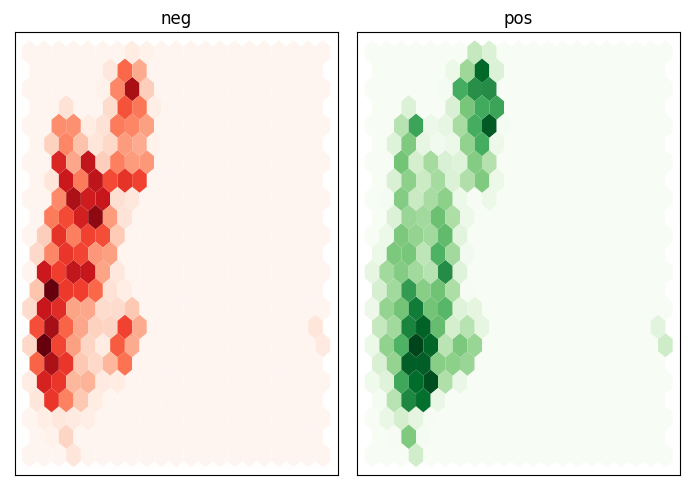

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(7,5))
axes = axes.flatten()
cmaps = [ "Reds", "Greens"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

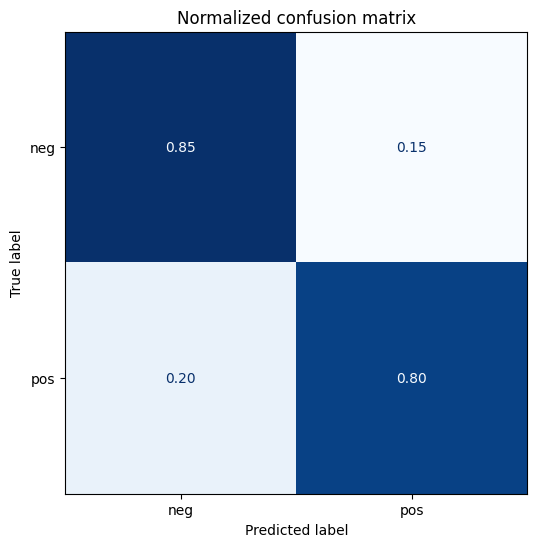

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [23]:
print("Accuracy: %.2f%%" % (lr_clf.score(X_valid, y_valid) * 100))

Accuracy: 82.93%


In [27]:
data = [
"Best Movie Ever 10/10", 
"Nice Movie",
"Deadpool & Wolverine is a fast, snappy, cheeky superhero self-parody that takes the mickey out of a franchise that has made billions.",
"Some of the jokes land through sheer volume and force of will, but it feels like you have to endure 40-or-so rectal stabbings for a single juicy zinger.",
"The worst Wolverine or Marvel movie ever.", 
"Terrible story and just completely ridiculous.", 
"I usually love Ryan Reynolds’s but this was his worst movie ever",
'Awesome... I\'ve already seen it twice. Everything from the music to the action sequences, passing through the cameos. I\'m sure to watch it again when it becomes available in Disney plus. The best thing that has come out of Marvel since End Game. Even the antagonist (Cassandra) when asked why she does what she does the answer is "I wish I knew" that line right there is brilliant. Do yourself a favor and go see it with a big bucket of popcorn.',
 'Amazing brought back so many memories of my Childhood watching Xmen 97',
 'Dont waste your money. This was the worst movie Ive ever seen.',
 'Loved it!  Would watch over and over again!',
 'It is a movie that grips you from the beginning, and one by one drops hints which begs you to think what happened earlier and what is about to happen. A really captivating movie with a good twist',
  'Slow in the beginning, confused in the middle, and I was mad there was so kids in the end! But still an okay movie!'
]
# df = pd.DataFrame(data,columns=["text"])
# df

In [28]:
text = "Terrible story and just completely ridiculous."
def perdict(text):
    inputs = tokenizer(text, return_tensors="pt")
    output = extract_hidden_states(inputs)
    prid = lr_clf.predict(output['hidden_state'])
    if prid:
        return "Positive"
    else:
        return "Negative"
    
res = [perdict(text) for text in data]

In [32]:
df = pd.DataFrame({
    'text': data, 
    'perdict_label': res,
    'Expected': ["pos", "pos", "pos", "neg", "neg", "neg", "neg","pos","pos","neg","pos","pos","neg"]
})
df

,text,perdict_label,Expected
0,Best Movie Ever 10/10,Positive,pos
1,Nice Movie,Positive,pos
2,"Deadpool & Wolverine is a fast, snappy, cheeky...",Positive,pos
3,Some of the jokes land through sheer volume an...,Negative,neg
4,The worst Wolverine or Marvel movie ever.,Negative,neg
5,Terrible story and just completely ridiculous.,Negative,neg
6,I usually love Ryan Reynolds’s but this was hi...,Negative,neg
7,Awesome... I've already seen it twice. Everyth...,Positive,pos
8,Amazing brought back so many memories of my Ch...,Positive,pos
9,Dont waste your money. This was the worst movi...,Negative,neg
